In [0]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)
  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached statsmodels-0.14.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Using cached numpy-1.22.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached packaging-24.0-py3-none-any.whl (53 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c61f64d8-88f8-43c4-88cf-ee417c1f68a2
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.2
    Not uninstalling patsy at /databricks/python3/lib/python3.9/site-packages, outside

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import pandas as pd
import numpy as np 
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)
spark = SparkSession.builder.getOrCreate()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
new_companies_trend_df = pd.read_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/new_companies_trend-1.csv")
old_companies_trend_df = pd.read_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/old_companies_trend-2.csv")

In [0]:
def extract_dates_and_values(s):
    if isinstance(s, str):
        dates = re.findall(r'\w{3} \d{1,2}, \d{4}', s)
        scores = re.findall(r'\d+(?=[\u202a\u202c][A-Za-z]{3} \d+,)', s)
        if dates == [] or scores == []:
            return None, None
        return dates[:-1], scores[1:]
    else:
        return None, None

old_companies_trend_df['name'] = old_companies_trend_df['input_url'].apply(lambda url: url.split('q=')[-1])
old_companies_trend_df[['dates', 'scores']] = old_companies_trend_df['table'].apply(lambda x: pd.Series(extract_dates_and_values(x)))
old_companies_trend_df = old_companies_trend_df[['name', 'dates', 'scores']]

new_companies_trend_df['name'] = new_companies_trend_df['input_url'].apply(lambda url: url.split('q=')[-1])
new_companies_trend_df[['dates', 'scores']] = new_companies_trend_df['table'].apply(lambda x: pd.Series(extract_dates_and_values(x)))
new_companies_trend_df = new_companies_trend_df[['name', 'dates', 'scores']]

In [0]:
print('number of records that return without data for the old companies: ', old_companies_trend_df.shape[0] - old_companies_trend_df.dropna().shape[0])
print('number of records that return without data for the new companies: ', new_companies_trend_df.shape[0] - new_companies_trend_df.dropna().shape[0])

old_companies_trend_df = old_companies_trend_df.dropna()
new_companies_trend_df = new_companies_trend_df.dropna()
old_companies_trend_df = old_companies_trend_df.drop_duplicates(subset='name')
new_companies_trend_df = new_companies_trend_df.drop_duplicates(subset='name')

number of records that return without data for the old companies:  3577
number of records that return without data for the new companies:  429


In [0]:
# old companies

old_companies_trend_df['scores'] = old_companies_trend_df['scores'].apply(lambda x: (np.array(x).astype(int)))
# remove 0 values from the begining of the time series
old_companies_trend_df['index_to_drop'] = old_companies_trend_df['scores'].apply(lambda x: np.where(x != 0)[0][0] if len(np.where(x != 0)[0]) > 0 else 0)
old_companies_trend_df['scores'] = old_companies_trend_df.apply(lambda row: row['scores'][row['index_to_drop']:], axis=1)
old_companies_trend_df['dates'] = old_companies_trend_df.apply(lambda row: row['dates'][row['index_to_drop']:], axis=1)

# remove records without enough data
old_companies_trend_df = old_companies_trend_df[old_companies_trend_df['scores'].apply(lambda x: len(x) > 51)]
old_companies_trend_df = old_companies_trend_df[old_companies_trend_df['scores'].apply(lambda x: (np.percentile(x, 50) > 0))]

In [0]:
# new companies

new_companies_trend_df['scores'] = new_companies_trend_df['scores'].apply(lambda x: (np.array(x).astype(int)))
# remove 0 values from the begining of the time series
new_companies_trend_df['index_to_drop'] = new_companies_trend_df['scores'].apply(lambda x: np.where(x != 0)[0][0] if len(np.where(x != 0)[0]) > 0 else 0)
new_companies_trend_df['scores'] = new_companies_trend_df.apply(lambda row: row['scores'][row['index_to_drop']:], axis=1)
new_companies_trend_df['dates'] = new_companies_trend_df.apply(lambda row: row['dates'][row['index_to_drop']:], axis=1)

# remove records without enough data
new_companies_trend_df = new_companies_trend_df[new_companies_trend_df['scores'].apply(lambda x: len(x) > 104)]
new_companies_trend_df = new_companies_trend_df[new_companies_trend_df['scores'].apply(lambda x: (np.percentile(x, 50) > 0))]

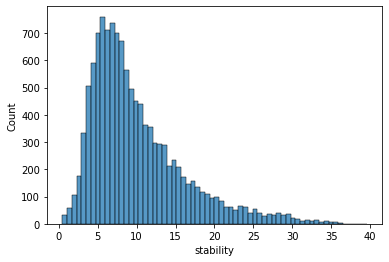

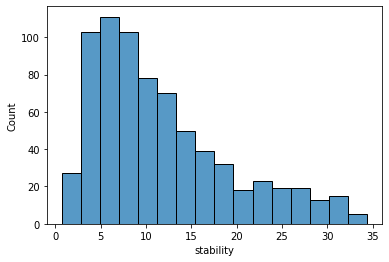

In [0]:
# old stability score
old_companies_trend_df['12_month_moving_std'] = old_companies_trend_df['scores'].apply(lambda x: np.array(pd.Series(x).rolling(window=12).std().dropna()))
old_companies_trend_df['stability'] = old_companies_trend_df['12_month_moving_std'].apply(lambda x: np.nanpercentile(x, 75))

# new stability score
new_companies_trend_df['12_month_moving_std'] = new_companies_trend_df['scores'].apply(lambda x: np.array(pd.Series(x).rolling(window=12).std().dropna()))
new_companies_trend_df['stability'] = new_companies_trend_df['12_month_moving_std'].apply(lambda x: np.nanpercentile(x, 75))


sns.histplot(old_companies_trend_df['stability'])
plt.show()

sns.histplot(new_companies_trend_df['stability'])
plt.show()

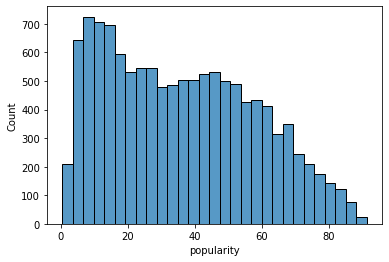

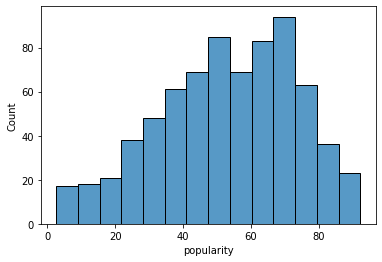

In [0]:
# popularity score
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def compute_popularity_score(scores_list):
    total_scores = len(scores_list)
    weights = np.array([(i**(1/3)) for i in range(total_scores)])
    weights = softmax(weights)
    popularity_score = np.sum(np.array(scores_list) * weights)
    return popularity_score

old_companies_trend_df['popularity'] = old_companies_trend_df['scores'].apply(compute_popularity_score)
new_companies_trend_df['popularity'] = new_companies_trend_df['scores'].apply(compute_popularity_score)

sns.histplot(old_companies_trend_df['popularity'])
plt.show()
sns.histplot(new_companies_trend_df['popularity'])
plt.show()

In [0]:
# growth score

def growth_score(scores, dates):
    time_series = pd.Series(data=scores, index=dates)
    decomposition = seasonal_decompose(time_series, model='additive')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    model_fit_auto = auto_arima(trend.dropna(), seasonal=True)
    FORECAST = 12
    next12m = model_fit_auto.predict(n_periods=FORECAST)
    return (next12m.iloc[-1] - next12m.iloc[0]) / FORECAST

# old_companies_trend_df['dates'] = old_companies_trend_df['dates'].apply(lambda x: [pd.to_datetime(date_str, format='%b %d, %Y') for date_str in x])
# old_companies_trend_df['12_month_moving_mean'] = old_companies_trend_df['scores'].apply(lambda x: np.array(pd.Series(x).rolling(window=12).mean().dropna()))
# old_companies_trend_df['growth'] = old_companies_trend_df['12_month_moving_mean'].apply(growth_score)

new_companies_trend_df['dates'] = new_companies_trend_df['dates'].apply(lambda x: [pd.to_datetime(date_str, format='%b %d, %Y') for date_str in x])
new_companies_trend_df['scores'] = new_companies_trend_df['scores'].apply(lambda x: np.array(pd.Series(x).dropna()))
new_companies_trend_df['growth'] = new_companies_trend_df.apply(lambda x: growth_score(x['scores'], x['dates']), axis=1)

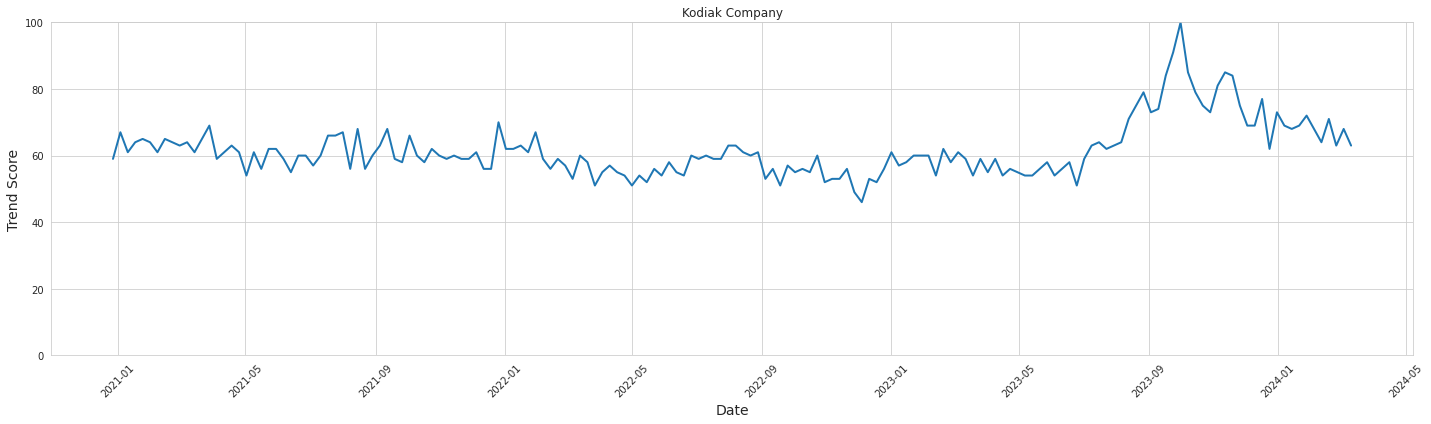

In [0]:
# names = old_companies_trend_df[(old_companies_trend_df['popularity'] > 2) & (old_companies_trend_df['popularity'] < 100)]['name'].unique()

# for a in names:
# a = 'Scholastic'
a = 'Kodiak'
dates = list(new_companies_trend_df[new_companies_trend_df['name'] == a]['dates'])[0]
numbers = list(new_companies_trend_df[new_companies_trend_df['name'] == a]['scores'])[0]

data = list(zip(dates, numbers))
new_df = pd.DataFrame(data, columns=['dates', 'numbers'])
new_df['dates'] = pd.to_datetime(new_df['dates'])

# Set the style
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(20, 6))  # Adjust the figure size
sns.lineplot(data=new_df, x='dates', y='numbers', linewidth=2)

plt.ylim(0,100)

# Set labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Trend Score', fontsize=14)
plt.title(f'{a} Company')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
new_companies_trend_df

,name,dates,scores,index_to_drop,12_month_moving_std,stability,popularity,12_month_moving_mean,growth
0,30 Friends,"[2019-12-29 00:00:00, 2020-01-05 00:00:00, 202...","[56, 45, 45, 48, 48, 38, 46, 52, 54, 43, 33, 3...",0,"[6.934214687571573, 6.459078647121195, 7.60532...",10.178706,70.258108,"[45.416666666666664, 45.083333333333336, 46.25...",-0.001508
4,OFFSET,"[2019-12-29 00:00:00, 2020-01-05 00:00:00, 202...","[26, 27, 29, 28, 34, 31, 30, 34, 35, 33, 30, 2...",0,"[3.325748947320898, 3.1430539096216403, 3.1430...",4.634358,28.145337,"[30.166666666666668, 30.333333333333332, 30.33...",-0.009387
7,Small Business Tips,"[2019-12-29 00:00:00, 2020-01-05 00:00:00, 202...","[38, 40, 35, 30, 33, 29, 25, 27, 40, 29, 31, 6...",0,"[10.1085022719401, 10.577276959538683, 16.1910...",5.316498,26.810819,"[35.0, 35.666666666666664, 38.833333333333336,...",-0.011512
9,Pindustry,"[2021-03-28 00:00:00, 2021-04-04 00:00:00, 202...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 20, 76, ...",13,"[3.848455022552045, 5.940997773560814, 22.0349...",7.309576,23.122992,"[1.5833333333333333, 2.25, 8.583333333333334, ...",0.017204
23,Ampere EV,"[2020-02-16 00:00:00, 2020-02-23 00:00:00, 202...","[25, 0, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3...",7,"[10.544278931336091, 8.371578903249572, 8.3715...",19.104775,49.581029,"[4.5, 2.4166666666666665, 2.4166666666666665, ...",0.142496
...,...,...,...,...,...,...,...,...,...
4969,Nil,"[2021-12-26 00:00:00, 2022-01-02 00:00:00, 202...","[46, 65, 60, 53, 59, 71, 100, 100, 80, 80, 76,...",0,"[16.838583039789267, 14.78840659763484, 14.890...",7.354652,66.359892,"[71.58333333333333, 73.83333333333333, 75.5833...",-0.074823
4973,Drop,"[2019-12-29 00:00:00, 2020-01-05 00:00:00, 202...","[90, 62, 64, 57, 62, 60, 64, 62, 68, 77, 64, 6...",0,"[9.01513878277685, 4.91981152632349, 4.8989794...",5.690902,72.624758,"[66.0, 63.75, 64.0, 64.58333333333333, 65.5, 6...",-0.011979
4985,Chiki Chiki Boom Boom,"[2019-12-29 00:00:00, 2020-01-05 00:00:00, 202...","[23, 15, 27, 17, 22, 17, 15, 14, 21, 0, 12, 12...",0,"[6.9167123036099385, 6.761634193720996, 8.2112...",9.745240,18.245948,"[16.25, 16.083333333333332, 14.833333333333334...",-0.098663
4992,World Aerospace,"[2019-12-29 00:00:00, 2020-01-05 00:00:00, 202...","[53, 30, 27, 37, 52, 52, 48, 46, 38, 50, 42, 4...",0,"[8.717797887081348, 9.509166231812465, 8.89799...",11.687860,56.112922,"[43.0, 40.666666666666664, 41.583333333333336,...",0.002254


In [0]:
companies = spark.read.parquet('/linkedin/companies')

In [0]:
def preprocess_company_names(df):
  df_names = df['name'].to_list()
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  search_name_list = []
  real_name_dict = {}

  for name in df_names:
      real_name = name
      # Remove special characters
      name = re.sub(r'\bInc.\b', '', name).strip()
      name = re.sub(r'\bInc\b', '', name).strip()
      name = re.sub(r'\bCo.\b', '', name).strip()
      name = re.sub(r'[^\w\s.,&()-]', '', name)

      if '-' in name or ',' in name or '(' in name:
        if '-' in name:
          parts = name.split('-')
          name = parts[0].strip()  # Get the part before the hyphen and remove any leading/trailing whitespace

        if ',' in name:
          parts = name.split(',')
          name = parts[0].strip()  # Get the part before the hyphen and remove any leading/trailing whitespace
      
        if '(' in name:
          parts = name.split('(')
          informative_part = parts[-1].strip()  # Get the part before the hyphen and remove any leading/trailing whitespace
          informative_part = informative_part.split(')')[0].strip()
          if informative_part.isupper():
            name = informative_part
          else: 
            name = parts[0].strip()

    #   search_name_list.append(name)
      real_name_dict[name] = real_name

  return real_name_dict

In [0]:
# old companies 
old_companies = companies.filter((col('founded') >= '1900') & (col('founded') < '2020'))
old_companies_df = old_companies.toPandas()

# new companies 
new_companies = companies.filter((col('founded') >= '2020') & (col('founded') < '2025'))
new_companies_df = new_companies.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field affiliated. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('Links', StringType(), True), StructField('location', StringType(), True), StructField('subtitle', StringType(), True), StructField('title', StringType(), True)]), True)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field af

In [0]:
old_real_name_dict = preprocess_company_names(old_companies_df)
old_companies_trend_df = old_companies_trend_df.rename(columns={'name':'search_name'})
old_companies_trend_df['name'] = old_companies_trend_df['search_name'].map(old_real_name_dict)

new_real_name_dict = preprocess_company_names(new_companies_df)
new_companies_trend_df = new_companies_trend_df.rename(columns={'name':'search_name'})
new_companies_trend_df['name'] = new_companies_trend_df['search_name'].map(new_real_name_dict) 

In [0]:
# old_companies_trend_df.to_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/old_companies_trend_preprocess", header=True)
new_companies_trend_df.to_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/new_companies_trend_preprocess - final", header=True)